# CNN model for SDM of 5 European Tree Species from satellite imagery
## A project for the module 700493: Modern concepts and methods in macroecology and biogeography

### 1. Decompressing .zstd file with satellite image squares

In [1]:
#import zstandard
#import pathlib

#dctx = zstandard.ZstdDecompressor()
#with open("..//input//satellite-cutouts//cutouts.h5.zstd",'rb') as ifh, open("//kaggle//working//cutouts.h5", 'wb') as ofh: dctx.copy_stream(ifh, ofh)

### 2. Extract satellite images from .h5 file

In [2]:
import os
import h5py
import numpy as np

#print(os.getcwd())

f = h5py.File("..//input//sat-cutouts/cutouts.h5","r")

#f.keys()
#np.array(f["labels"])
#np.array(f["data"]["1"])

### 3. Filter images with unique coordinates only

In [3]:
import pandas as pd

x_coord = np.array(f["x"])
y_coord = np.array(f["y"])
label = np.array(f["labels"])
#print(label)
np.unique(label, return_counts=True)
images_df = pd.DataFrame(np.vstack([x_coord, y_coord, label]).T, columns = ["X", "Y", "SPECIES.NAME"])

images_df["SPECIES.NAME"].nunique()

images_df_unique = images_df.drop_duplicates(subset = ["X", "Y"])
#print(images_df_unique)
#print(images_df_unique.index)

### 4. Check how many trees per species are in the unique dataset

In [4]:
images_df_unique["SPECIES.NAME"].value_counts()

b'Pinus sylvestris'    49377
b'Picea abies'         41487
b'Fagus sylvatica'     24026
b'Quercus robur'       22913
b'Betula pubescens'    13076
Name: SPECIES.NAME, dtype: int64

### 5. Create subset


In [5]:
sample_indeces = images_df_unique.groupby("SPECIES.NAME", group_keys = False).apply(lambda x: x.sample(n = 2500, random_state = 123)).index
#print(sample_indeces)
subset_df = images_df_unique.loc[sample_indeces]
subset_images = np.array([np.array(f["data"][str(i+1)]) for i in sample_indeces])

#np.save("subset_images.npy", subset_images)
#subset_df.to_csv("df_subset_images.csv")

### 6. Print example satellite image

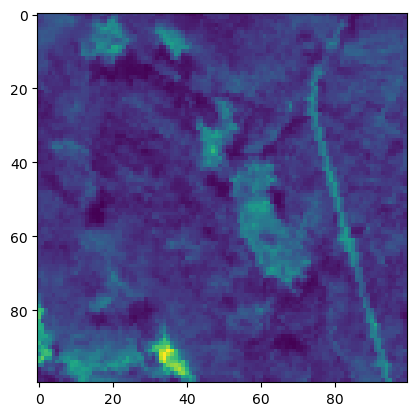

In [6]:
from matplotlib import pyplot as plt
plt.imshow(subset_images[0, 3])
#plt.savefig('satellite_exp.png')

### 7. Normalization of pixel values

In [7]:
#np.min(subset_images), np.max(subset_images)
subset_images = (subset_images - np.min(subset_images)) / (np.max(subset_images) - np.min(subset_images))
#print(subset_images.dtype)
#print(subset_images.shape)

### 8. Create training and test datset

#### 8.1 Change data structure

In [8]:
from matplotlib import pyplot as plt
import torch

#print(subset_images.shape)
subset_images_new = np.rollaxis(subset_images, 1, 4)
# print(subset_images_new.shape)
subset_images_tensor = torch.from_numpy(subset_images)

#### 8.2 Transform labels to numbers

In [9]:
labels = subset_df["SPECIES.NAME"].values # .values makes sure to get values and not pandas series object

labels_dict = {b'Fagus sylvatica':0, b'Picea abies':1, b'Betula pubescens':2, b'Pinus sylvestris':3, b'Quercus robur':4}

labels = subset_df["SPECIES.NAME"].apply(lambda x: labels_dict[x]).values

#### 8.3 Train-test-split

In [10]:
from sklearn.model_selection import train_test_split

index_train, index_test, img_train, img_test, label_train, label_test = train_test_split(subset_df.index.values, subset_images_tensor, labels, stratify=labels, test_size=0.2, random_state=42)


#### 8.4 add training and test set information to data frame

In [11]:
subset_df.loc[index_train, ["training"]]=True
subset_df.loc[index_test, ["training"]]=False
#subset_df
#print(np.unique(label_test, return_counts=True)) # check distribution of labels in test set

### 9. Create dataset

#### 9.1 Create dataset class

In [12]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, labels, images):
        self.img_labels = labels
        self.img = images

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img[idx]
        label = self.img_labels[idx]
        return image, label

#### 9.2 Create train and test datasets

In [13]:
training_data = CustomImageDataset(label_train, img_train)
#print(training_data.img.shape)

test_data = CustomImageDataset(label_test, img_test)
#print(test_data.img.shape)

### 10. Specify a batch size

In [14]:
batch_size = 32

### 11. Create data loaders

In [15]:
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

#for X, y in train_dataloader:
#    print("Shape of X: ", X.shape, X.dtype)
#    print("Shape of y: ", y.shape, y.dtype)
#    break

### 12. Define the CNN model

In [16]:
import torch.nn.functional as F

class TreeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(4, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 22 * 22, 120)
        self.do1 = torch.nn.Dropout(p=0.2) # cite dropout
        self.fc2 = torch.nn.Linear(120, 84)
        self.do2 = torch.nn.Dropout(p=0.2)
        self.fc3 = torch.nn.Linear(84, 5)

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.do1(self.fc1(x)))
        x = F.relu(self.do2(self.fc2(x)))
        #x = F.softmax(self.fc3(x), dim=1) # may not work (maybe needs higher learning rate)
        x = self.fc3(x) # may not work (maybe needs higher learning rate)

        return x

# check if GPU is availavle
device = "cuda" if torch.cuda.is_available() else "cpu"
#print("Using {} device".format(device))

# get the model and move to available device
model = TreeModel().to(device)
#print(model)

### 13. Define the loss function and the optimizer

In [17]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 14. Define training, test and predict functions

In [18]:
# The training function
def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward propagation or Compute prediction error
        pred = model(X)
        loss = loss_function(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_loss = loss
    return train_loss      

# The test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

# The predict function
def predict(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    list_preds = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            list_preds.append(pred.numpy())
    return np.vstack(list_preds)

### 15. Run the model

In [19]:
epochs = 6
train_loss_list = []
test_loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss, optimizer)
    test_loss = test(test_dataloader, model, loss)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 1.589754  [    0/10000]
loss: 1.539603  [  640/10000]
loss: 1.481276  [ 1280/10000]
loss: 1.544152  [ 1920/10000]
loss: 1.438823  [ 2560/10000]
loss: 1.339813  [ 3200/10000]
loss: 1.388286  [ 3840/10000]
loss: 1.434744  [ 4480/10000]
loss: 1.347971  [ 5120/10000]
loss: 1.472815  [ 5760/10000]
loss: 1.223549  [ 6400/10000]
loss: 1.294842  [ 7040/10000]
loss: 1.357797  [ 7680/10000]
loss: 1.265072  [ 8320/10000]
loss: 1.257622  [ 8960/10000]
loss: 1.381280  [ 9600/10000]
Test Accuracy: 38.9%, Avg loss: 1.333631 

Epoch 2
-------------------------------
loss: 1.395749  [    0/10000]
loss: 1.285938  [  640/10000]
loss: 1.344863  [ 1280/10000]
loss: 1.251901  [ 1920/10000]
loss: 1.441432  [ 2560/10000]
loss: 1.354064  [ 3200/10000]
loss: 1.390238  [ 3840/10000]
loss: 1.429544  [ 4480/10000]
loss: 1.379230  [ 5120/10000]
loss: 1.476512  [ 5760/10000]
loss: 1.186631  [ 6400/10000]
loss: 1.296092  [ 7040/10000]
loss: 1.307875  [ 7680/10000]
loss: 1

### 16. Plot train and test loss

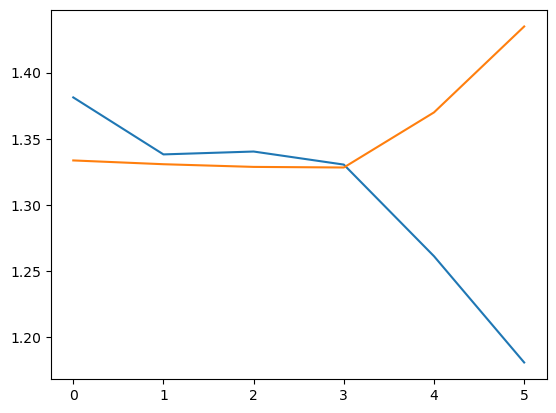

In [20]:
plt.plot(np.arange(epochs), train_loss_list)
plt.plot(np.arange(epochs), test_loss_list)
#plt.savefig('train_test_loss.png')

### 17. Accumulate predictions in dataframe

In [21]:
preds_test = predict(test_dataloader, model)

subset_df.loc[index_train, ["training"]]=True
subset_df.loc[index_test, ["sp1", "sp2", "sp3", "sp4", "sp5"]]=preds_test

preds_train = predict(train_dataloader, model)
subset_df.loc[index_train, ["sp1", "sp2", "sp3", "sp4", "sp5"]]=preds_train

labels_dict_rev = {0:"b'Fagus sylvatica'",
              1:"b'Picea abies'",
              2:"b'Betula pubescens'",
              3:"b'Pinus sylvestris'",
              4:"b'Quercus robur'"}

preds_test
subset_df.loc[index_test, ["prediction"]]=[labels_dict_rev[i] for i in np.argmax(preds_test, axis=1)]
subset_df.loc[index_train, ["prediction"]]=[labels_dict_rev[i] for i in np.argmax(preds_train, axis=1)]
subset_df.to_csv("results.csv")